In [1]:
import jax
import jax.numpy as jnp

from experior.utils import PRNGSequence, moving_average
import matplotlib.pyplot as plt
from experior.envs import BayesStochasticBandit
from gymnax.environments import spaces


jax.config.update("jax_debug_nans", True)

%load_ext autoreload
%autoreload 2


## ISSUES
1. Diverging when optimizing both lambda and alpha
2. Estimating the expert distribution is not efficient (expert_mc_samples)
3. The value of beta is different between the generated samples and the likelihood estimation
4. How to show the derived prior makes sense? Is it close to the true prior in any sense? E.g., compared to the standard gaussian
5. Multi-armed bandit experiment

In [2]:
ts_config = {
  "langevin_learning_rate": 0.01,
  "langevin_batch_size": 128,
  "langevin_updates_per_step": 10
}
max_ent_config = {
  "langevin_learning_rate": 0.01,
  "langevin_batch_size": 128,
  "langevin_updates_per_step": 10,
  "max_ent_epsilon": 1e-3,
  "max_ent_prior_n_samples": 1000,
  "max_ent_steps": 1000,
  "max_ent_learning_rate": 1e-3,
  "max_ent_lambda": 10.,
  "expert_beta": 1.,
  "init_emp_ent": 0.,
}

## Expert Entropy and Episodes Effect

### Environment

In [99]:
NUM_ACTIONS = 5
NUM_ENVS = 50
NUM_STEPS = 5000
N_TRAJECTORY = 1000
HORIZON = 1

rng = PRNGSequence(42)

import itertools
from typing import Optional
alpha_values = [0.5, 4.]
beta_values = [0.5, 4.]
alpha_betas = itertools.product(alpha_values, beta_values)
alpha_betas = jnp.array(list(itertools.product(alpha_betas, repeat=5)))

action_space = spaces.Discrete(NUM_ACTIONS)
def prior_function(key, i: Optional[int] = 0):
  return jax.random.beta(key, alpha_betas[i, :, 0], alpha_betas[i, :, 1])
prior_function = jax.tree_util.Partial(prior_function)
reward_dist_fn = jax.tree_util.Partial(lambda key, means, _, action: jax.random.bernoulli(key, means[action]).astype(jnp.float32))
best_action_value_fn = jax.tree_util.Partial(lambda means, _: (means.argmax(), means.max()))
reward_mean_fn = jax.tree_util.Partial(lambda means, _, action: means[action])
mutli_armed_bandit = BayesStochasticBandit(action_space, prior_function, reward_dist_fn, reward_mean_fn, best_action_value_fn)

### Generate Expert Trajectories

In [100]:
from experior.experts import generate_optimal_trajectories
expert_trajectories = jax.vmap(generate_optimal_trajectories, in_axes=(None, None, None, None, 0))(
    next(rng), mutli_armed_bandit, N_TRAJECTORY, 1, jnp.arange(alpha_betas.shape[0])
)

In [101]:
# calculate the entropy of each expert trajectory
epsilon = 1e-8
entropy_fn = lambda exp_traj: - jax.vmap(lambda p: p * jnp.log(p+epsilon))(jnp.bincount(exp_traj.action.flatten(), length=NUM_ACTIONS) / N_TRAJECTORY).sum()
expert_entropies = jax.vmap(entropy_fn)(expert_trajectories)


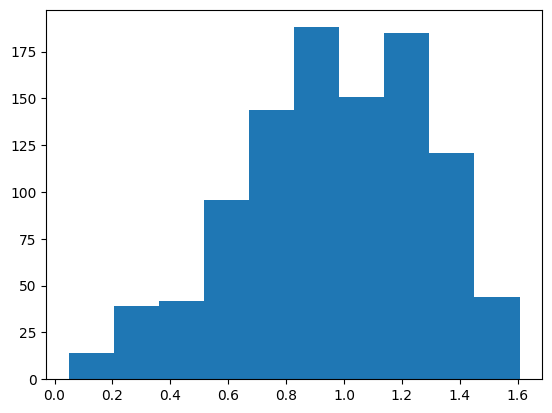

In [102]:
plt.hist(expert_entropies.sort())
plt.show()

### No Entropy Thompson Sampling

In [123]:
from experior.bandit_agents import LinearDiscreteRewardModel
from experior.bandit_agents import make_thompson_sampling

jax.config.update("jax_disable_jit", False)

feature_fn = jax.tree_util.Partial(lambda obs, action: jax.nn.one_hot(action, NUM_ACTIONS))
prior_log_pdf = jax.tree_util.Partial(lambda params, _: jnp.zeros((1,)))


reward_model = LinearDiscreteRewardModel(n_actions=NUM_ACTIONS,
                                        params_dim=NUM_ACTIONS,
                                        feature_fn=feature_fn,
                                        dist="bernoulli")
ts_train = make_thompson_sampling(env=mutli_armed_bandit,
                                  reward_model=reward_model,
                                  prior_log_pdf=prior_log_pdf,
                                  num_envs = NUM_ENVS,
                                  total_steps=NUM_STEPS,
                                  **ts_config)

rng_key = next(rng)
state, no_prior_metrics = jax.vmap(jax.jit(ts_train), in_axes=(None, 0))(
    rng_key, jnp.arange(alpha_betas.shape[0])
)


/h/vdblm/.jax_env/lib/python3.9/site-packages/jax/_src/numpy/array_methods.py:728: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(self.aval, name).fun(self, *args, **kwargs)


In [150]:
no_prior_regret = (no_prior_metrics['optimal_value'] - no_prior_metrics['reward_mean']).mean(axis=-1).cumsum(axis=1)

In [151]:
no_prior_metrics['optimal_value'] - no_prior_metrics['reward_mean']

Array([1.9152658e-01, 3.9165050e-01, 5.8734298e-01, ..., 2.3866127e+02,
       2.3870111e+02, 2.3874095e+02], dtype=float32)

In [152]:
no_prior_metrics['optimal_value'][1102, :,20]

Array([0.5977542, 0.5977542, 0.5977542, ..., 0.5977542, 0.5977542,
       0.5977542], dtype=float32)

In [153]:
no_prior_metrics['reward_mean'][1102, :, 20]

Array([0.48524275, 0.5977542 , 0.56330055, ..., 0.48524275, 0.48524275,
       0.48524275], dtype=float32)

### True Prior Thompson Sampling

### Max Entropy Thompson Sampling

In [65]:
from experior.bandit_agents import make_max_ent_thompson_sampling
max_ent_ts_train = make_max_ent_thompson_sampling(env=mutli_armed_bandit,
                                                  reward_model=reward_model,
                                                  num_envs=NUM_ENVS,
                                                  total_steps=NUM_STEPS,
                                                  **max_ent_config)

state, max_ent_state, max_ent_metrics = jax.vmap(jax.jit(max_ent_ts_train), in_axes=(None, 0, 0))(
    rng_key, expert_trajectories, jnp.arange(alpha_betas.shape[0])
)

/h/vdblm/.jax_env/lib/python3.9/site-packages/jax/_src/numpy/array_methods.py:728: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(self.aval, name).fun(self, *args, **kwargs)


In [85]:
max_ent_regret = (max_ent_metrics['optimal_value'] - max_ent_metrics['reward']).mean(axis=-1).cumsum(axis=0)

In [80]:
max_ent_metrics["optimal_value"].mean(axis=-1)[101]

Array([0.90932053, 0.90932053, 0.90932053, ..., 0.90932053, 0.90932053,
       0.90932053], dtype=float32)

In [84]:
(max_ent_metrics["optimal_value"].mean(axis=-1) - max_ent_metrics["reward"].mean(axis=-1))[101]

Array([ 0.58932054, -0.03067946, -0.01067942, ..., -0.05067945,
       -0.03067946, -0.03067946], dtype=float32)

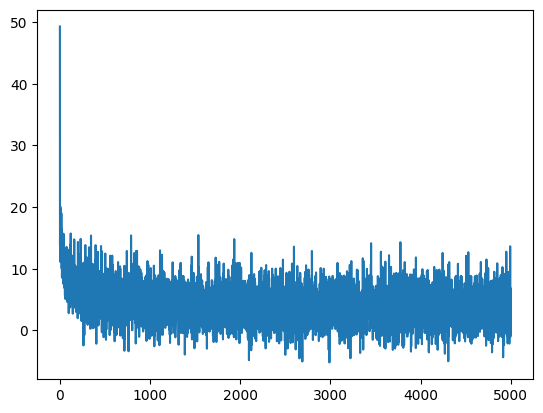

In [86]:
plt.plot(max_ent_regret[101])

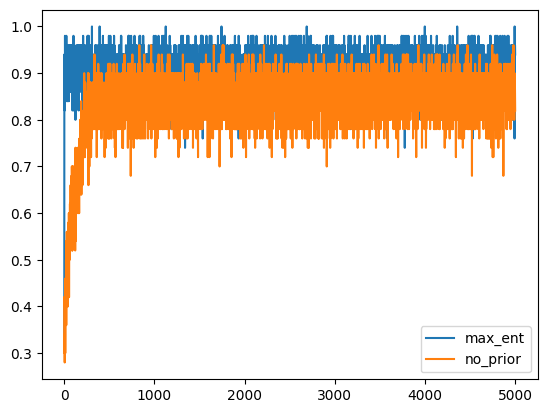

In [79]:
plt.plot(max_ent_metrics['reward'].mean(axis=-1)[101], label='max_ent')
plt.plot(no_prior_metrics['reward'].mean(axis=-1)[101], label='no_prior')
plt.legend()
plt.show()


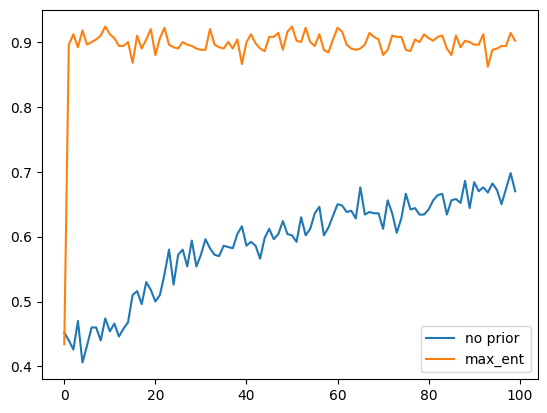

In [110]:
plt.plot(moving_average(no_prior_metrics["reward"].mean(axis=-1)[:100], 1), label="no prior")
plt.plot(moving_average(max_ent_metrics["reward"].mean(axis=-1)[:100], 1), label="max_ent")
# plt.plot(moving_average(true_out["metrics"].reward.mean(axis=0).reshape(-1,), 10), label="true prior")
plt.legend()
plt.show()
